# fully-connected neural network

In [ ]:
! conda activate tf-gpu

In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

## 1. dataset

In [4]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
# df['label'] = df['label'].map({'epitope':1, 'other': 0})
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_N,has_D,has_C,has_I,has_L,has_K,has_F,has_T,has_Y,has_V
2040933,DVISIDKTGENF,1,15.833333,0.879167,9.125000,0.140500,3.179167,-2.5,0.465,9.1,...,1,1,0,1,0,1,1,1,0,1
275402,KKANLEREEKKRDYQARKMHYLLST,0,9.840000,0.837600,9.488000,0.188280,4.139600,-14.0,0.610,10.5,...,1,1,0,0,1,1,0,1,1,0
1072372,HRVPQTDMTF,1,15.900000,0.824000,8.640000,0.180400,3.876000,10.5,0.605,8.6,...,0,1,0,0,0,0,1,1,0,1
534878,LQSLQVCVQTVRTQVY,1,36.062500,0.752500,7.750000,0.165437,3.601875,31.0,0.835,7.4,...,0,0,1,0,1,0,0,1,1,1
2177642,LEAQPRPFR,0,8.555556,1.081111,8.666667,0.188556,4.035556,-14.0,0.610,8.1,...,0,0,0,0,1,0,1,0,0,0


In [5]:
X = np.array(df.iloc[:,2:], dtype=np.float16)
y = np.array(df.iloc[:,1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

from collections import Counter
Counter(y)

(2490831, 46) float16 (2490831,) float16


Counter({np.float16(1.0): 1798795, np.float16(0.0): 692036})

In [6]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [7]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(1394864, 46) (1394864,)
(597800, 46) (597800,)
(498167, 46) (498167,)


## 2. train model

In [16]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,409 (286.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optim,
    metrics=['accuracy', 'precision', 'recall', 'auc', 'mse']
)

epochs = 50
history= model.fit(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=epochs,
    verbose=True
)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

Epoch 1/50
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.7541 - auc: 0.7180 - loss: 0.5265 - mse: 0.1735 - precision: 0.7675 - recall: 0.9466 - val_accuracy: 0.7632 - val_auc: 0.7461 - val_loss: 0.5103 - val_mse: 0.1672 - val_precision: 0.7677 - val_recall: 0.9632
Epoch 2/50
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.7665 - auc: 0.7466 - loss: 0.5076 - mse: 0.1658 - precision: 0.7798 - recall: 0.9431 - val_accuracy: 0.7747 - val_auc: 0.7570 - val_loss: 0.4988 - val_mse: 0.1620 - val_precision: 0.7932 - val_recall: 0.9301
Epoch 3/50
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.7707 - auc: 0.7564 - loss: 0.5007 - mse: 0.1630 - precision: 0.7855 - recall: 0.9387 - val_accuracy: 0.7737 - val_auc: 0.7617 - val_loss: 0.4986 - val_mse: 0.1619 - val_precision: 0.7932 - val_recall: 0.9284
Epoch 4/50
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.7729 - auc: 0.7606 - loss: 0.4970 - mse: 0.1616 - precision: 0.7884 - recall: 0.9375 - val_a

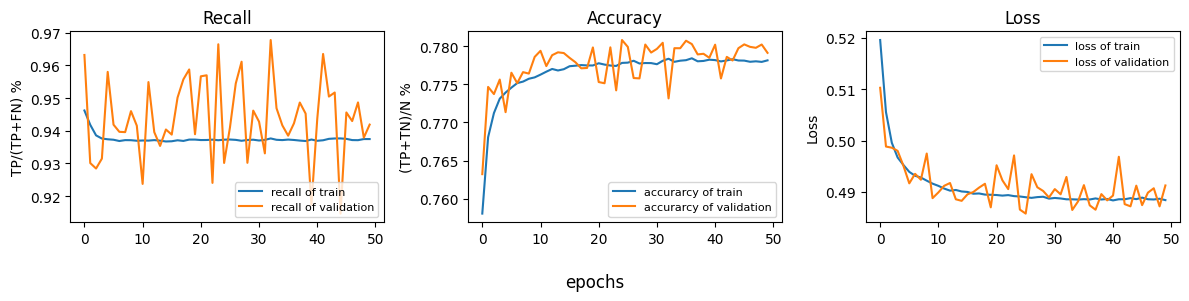

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [27]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

15568/15568 ━━━━━━━━━━━━━━━━━━━━ 15s 960us/step - accuracy: 0.7786 - auc: 0.7683 - loss: 0.4928 - mse: 0.1590 - precision: 0.7913 - recall: 0.9417
{'accuracy': 0.7786926627159119, 'auc': 0.7691832184791565, 'loss': 0.4921380281448364, 'mse': 0.15879803895950317, 'precision': 0.7913439273834229, 'recall': 0.9419378638267517}


In [29]:
# save entire model
model.save('../models/epitopes_ann.keras')

## test model

In [35]:
# load from file
model0 = tf.keras.models.load_model('../models/epitopes_ann.keras')
pred_test = model0.predict(X_test)
pred_test[:3]

15568/15568 ━━━━━━━━━━━━━━━━━━━━ 6s 379us/step


array([[0.95623034],
       [0.81539804],
       [0.34423664]], dtype=float32)

In [36]:
# use
pred_test = model.predict(X_test)
pred_test[:3]

15568/15568 ━━━━━━━━━━━━━━━━━━━━ 6s 378us/step


array([[0.95623034],
       [0.81539804],
       [0.34423664]], dtype=float32)

Text(0.5, 1.0, 'Prediction of non-epitopes 138380')

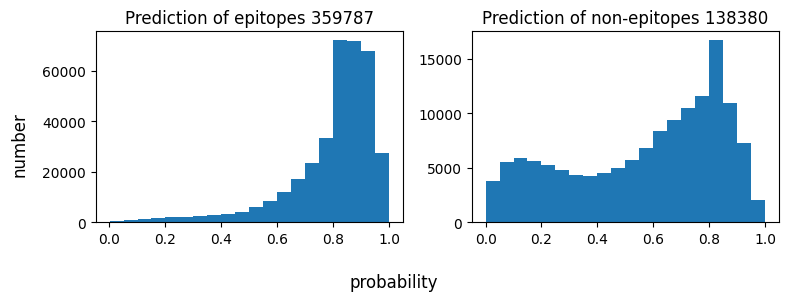

In [31]:
t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

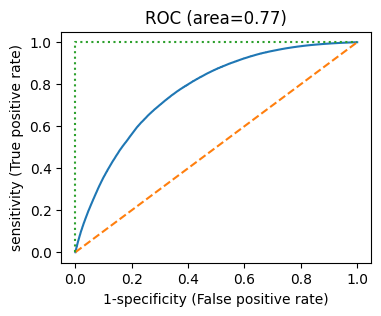

In [32]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')

(array([ 10710.,  14466.,  14209.,  13722.,  16805.,  26894.,  46863.,
         78830., 171158., 104510.]),
 array([3.05123773e-11, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 9.00000036e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

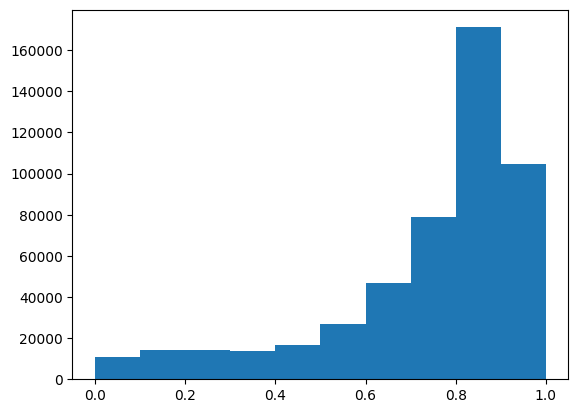

In [33]:
plt.hist(pred_test)

(array([138380.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 359787.]),
 array([0.        , 0.09997559, 0.19995117, 0.29980469, 0.39990234,
        0.5       , 0.59960938, 0.69970703, 0.79980469, 0.89990234,
        1.        ]),
 <BarContainer object of 10 artists>)

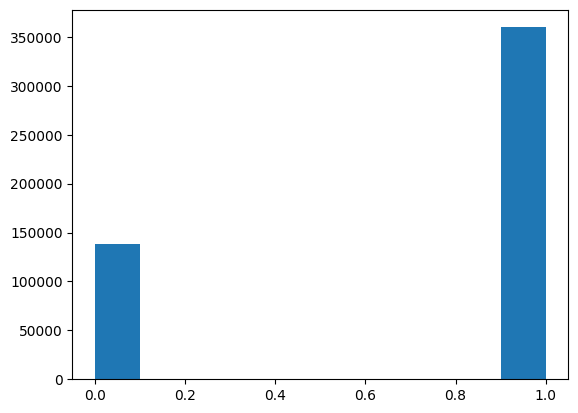

In [34]:
plt.hist(y_test)